# Introduction to Computational science - Assignment 2
Sander Broos, Nick van Santen

In [ ]:
# Imports
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np

from typing import Callable, List

In [ ]:
# Run cell to increase font sizes. Usefull when saving plots
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
class Event:

    def __init__(self, name: str, rate: Callable, event: dict):

        self.name = name
        self.event = event

        self.rate = rate

    def occur(self, groups, time):
        
        for group in self.event:
            groups[group].add_value(self.event[group], time)

class Simulator:

    def __init__(self, groups: List[Group], events: List[Event], max_time: float):

        self.groups = groups

        self.events = events

        self.time = 0
        self.max_time = max_time
        self.time_steps = [0]
    
    def update(self):

        total_rate = sum([event.rate(self.groups) for event in self.events])

        if total_rate == 0:
            self.time = self.max_time
            return

        r1 = np.random.rand()
        delta_time = -1 / total_rate * np.log(r1)

        r2 = np.random.rand()
        P = r2 * total_rate

        event = self.determine_event(P)

        self.time += delta_time

        if self.time > self.max_time:
            return

        self.time_steps.append(self.time)
        
        # Apply event
        event.occur(self.groups, self.time)

        
    def determine_event(self, p: float):
        
        value = 0
        for event in self.events:

            value += event.rate(self.groups)

            if value > p:
                return event
        
        print("ERROR: No event found")
        return None

    def run(self):

        while self.time < self.max_time:
            self.update()

        for group in self.groups.values():

            group.append_to_history(group.inhabitants, self.max_time)

    def plot_group_levels(self):

        for group in self.groups.values():

            plt.plot(group.time_steps, group.history, label=group.name, drawstyle="steps-post")

        plt.legend()
        plt.show()

class Group:

    def __init__(self, name: str, initial: int):
        
        self.name = name
        self.inhabitants = initial
        
        self.history = [initial]
        self.time_steps = [0]

    def add_value(self, value: int, time: float):

        self.inhabitants += value

        self.append_to_history(self.inhabitants, time)

    def append_to_history(self, value: int, time: float):
        
        self.history.append(value)
        self.time_steps.append(time)


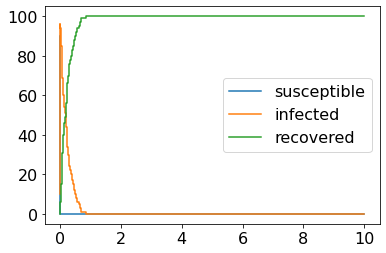

In [8]:
groups = {
    "susceptible": Group("susceptible", 90),
    "infected": Group("infected", 10),
    "recovered": Group("recovered", 0),
}

def transmission_rate(groups):
    return 10 * groups["infected"].inhabitants * groups["susceptible"].inhabitants

def recovery_rate(groups):
    return 5 * groups["infected"].inhabitants

events = [
    Event("transmission", transmission_rate, {"infected": 1, "susceptible": -1}),
    Event("recovery", recovery_rate, {"infected": -1, "recovered": 1}),
]

sim = Simulator(groups, events, 10)
sim.run()
sim.plot_group_levels()